In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [82]:
def cargar_matriz(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    for line in lines:
        if "DIMENSION" in line:
            n = int(line.strip().split(":")[1])
            break
    for idx, line in enumerate(lines):
        if "EDGE_WEIGHT_SECTION" in line:
            start_idx = idx + 1
            break
    costos = []
    for i in range(n):
        fila = list(map(int, lines[start_idx + i].strip().split()))
        fila = [999999 if x == -1 else x for x in fila]
        costos.append(fila)
    C = np.array(costos)
    prohibidos = np.sum(C == 999999)
    total = n * n
    print(f"Matriz cargada de dimensión {n}x{n}.")
    print(f"Porcentaje de arcos prohibidos: {prohibidos/total*100:.2f}%\n")
    return C

In [83]:
def costo_total(secuencia, C):
    return sum(C[secuencia[i], secuencia[i+1]] for i in range(len(secuencia)-1))

In [84]:
# Heurística Greedy
def greedy(C):
    n = C.shape[0]
    nodos = list(range(n))
    solucion = []
    actual = 0
    visitados = {actual}
    solucion.append(actual)
    while len(visitados) < n:
        costos_permitidos = [(j, C[actual, j]) for j in nodos if j not in visitados and C[actual, j] < 999999]
        if not costos_permitidos:
            return None, float('inf')
        siguiente = min(costos_permitidos, key=lambda x: x[1])[0]
        solucion.append(siguiente)
        visitados.add(siguiente)
        actual = siguiente
    return solucion, costo_total(solucion, C)

In [85]:
# Neighbourhood Search
def neighbourhood_search(C, iteraciones=100):
    n = C.shape[0]
    nodos = list(range(n))
    
    solucion = []
    actual = 0
    visitados = {actual}
    solucion.append(actual)
    while len(visitados) < n:
        costos_permitidos = [(j, C[actual, j]) for j in nodos if j not in visitados and C[actual, j] < 999999]
        if not costos_permitidos:
            return None, float('inf')
        siguiente = min(costos_permitidos, key=lambda x: x[1])[0]
        solucion.append(siguiente)
        visitados.add(siguiente)
        actual = siguiente

    mejor = solucion[:]
    mejor_costo = costo_total(mejor, C)

    for _ in range(iteraciones):
        i, j = sorted(random.sample(range(1, n), 2))
        nueva = mejor[:i] + mejor[i:j][::-1] + mejor[j:]
        nuevo_costo = costo_total(nueva, C)
        if nuevo_costo < mejor_costo:
            mejor, mejor_costo = nueva, nuevo_costo

    return mejor, mejor_costo

In [86]:
# GRASP
def grasp(C, alpha=0.3, iteraciones=100):
    n = C.shape[0]
    nodos = list(range(n))
    mejor_solucion = None
    mejor_costo = float('inf')

    for _ in range(iteraciones):
        solucion = []
        actual = 0
        visitados = {actual}
        solucion.append(actual)

        while len(visitados) < n:
            candidatos = [(j, C[actual, j]) for j in nodos if j not in visitados and C[actual, j] < 999999]
            if not candidatos:
                break
            candidatos.sort(key=lambda x: x[1])
            k = max(1, int(len(candidatos) * alpha))
            siguiente = random.choice(candidatos[:k])[0]
            solucion.append(siguiente)
            visitados.add(siguiente)
            actual = siguiente

        if len(visitados) < n:
            continue

        costo = costo_total(solucion, C)
        if costo < mejor_costo:
            mejor_solucion = solucion[:]
            mejor_costo = costo

    return mejor_solucion, mejor_costo

In [87]:
# Gráfico de la solución
def graficar_solucion(solucion, C, puntos, titulo):
    n = C.shape[0]
    plt.figure(figsize=(6, 6))
    for i in range(n):
        plt.scatter(puntos[i, 0], puntos[i, 1], c='blue')
        plt.text(puntos[i, 0]+0.01, puntos[i, 1]+0.01, str(i), fontsize=10)
    for i in range(len(solucion) - 1):
        plt.plot([puntos[solucion[i], 0], puntos[solucion[i+1], 0]],
                 [puntos[solucion[i], 1], puntos[solucion[i+1], 1]], 'r-')
    costo = costo_total(solucion, C)
    plt.title(f'{titulo} - Costo total: {costo}')
    plt.show()

Matriz cargada de dimensión 18x18.
Porcentaje de arcos prohibidos: 53.70%

Greedy: None, Costo: inf
Neighbourhood Search: None, Costo: inf
GRASP: [0, 17, 2, 1, 3, 4, 5, 6, 7, 16, 8, 9, 10, 11, 12, 13, 14, 15], Costo: 3663


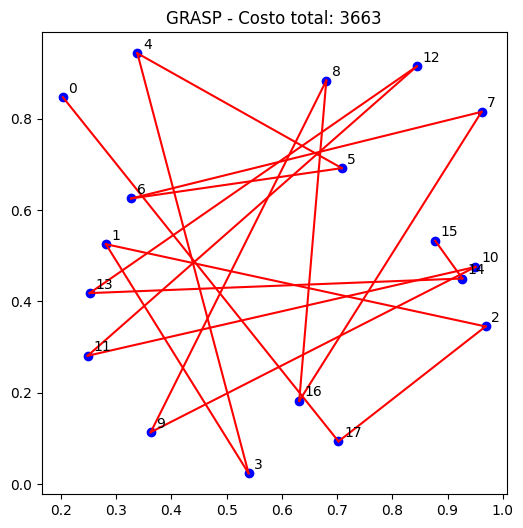

In [90]:
ruta = r'C:\Users\crhac\CATSSP\CATSSP\CGL\cgl_17.catsp'
C = cargar_matriz(ruta)
n = C.shape[0]

puntos = np.random.rand(n, 2)

solucion, costo = greedy(C)
print(f"Greedy: {solucion}, Costo: {costo}")
if solucion:
    graficar_solucion(solucion, C, puntos, "Greedy")

mejor_ns, costo_ns = neighbourhood_search(C)
print(f"Neighbourhood Search: {mejor_ns}, Costo: {costo_ns}")
if mejor_ns:
    graficar_solucion(mejor_ns, C, puntos, "Neighbourhood Search")

mejor_grasp, costo_grasp = grasp(C)
print(f"GRASP: {mejor_grasp}, Costo: {costo_grasp}")
if mejor_grasp:
    graficar_solucion(mejor_grasp, C, puntos, "GRASP")
